<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

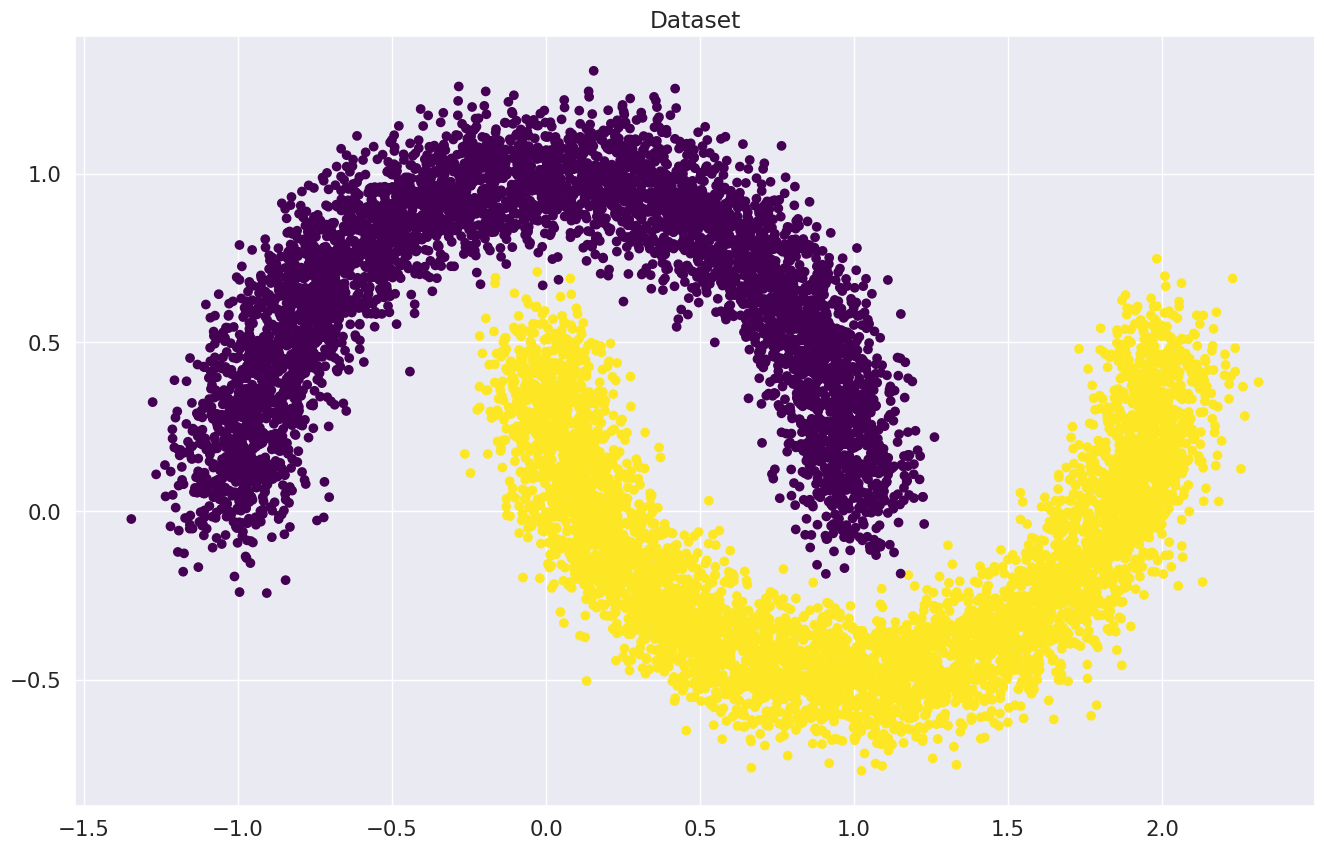

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train

array([[ 0.50202001, -0.33758011],
       [-0.02001968,  0.239079  ],
       [ 0.57026061,  0.81166576],
       ...,
       [ 0.32163146, -0.35671524],
       [ 2.01344205,  0.03227946],
       [ 0.17908235,  0.93097468]])

In [6]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1))
    def forward(self, x):
        x = (x*self.weights).sum(axis=1)
        if self.bias:
            x += self.bias_term
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
3

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        print(outp)
        loss = loss_function(outp, y_batch.float())
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

tensor([-0.9107,  0.0873, -0.5752,  1.5894,  1.4879, -1.3683, -1.7349,  0.5712,
        -2.8789,  0.3384, -0.9466, -1.4613, -2.5383,  1.4738, -0.7702, -1.4947,
         0.4737, -0.2456, -1.2146,  1.5408,  0.4747, -2.7844, -0.1217, -1.1830,
        -2.6182, -1.3366, -3.0623, -0.2102, -2.8555, -0.2044, -0.1820,  0.9152,
        -2.3250,  0.0558,  1.5076,  1.6088, -1.1592,  0.6930,  1.6329, -1.0864,
        -2.6369,  0.7923,  1.8289,  0.2915,  0.1389, -2.8401, -2.3422,  1.5149,
        -0.6197,  0.3225, -2.1844, -1.5905, -1.2793, -2.9912,  0.1398,  1.1208,
        -0.1668,  0.3793,  0.2649, -0.0112,  1.2662, -0.9012, -0.6002, -0.6262,
        -2.6811, -0.5895, -0.7497, -1.8993,  1.0966, -1.1316,  0.9586, -0.2877,
        -1.3365, -0.6741,  1.4246, -0.7217, -0.3228, -0.2982, -0.2031, -1.1214,
         0.7106, -1.8397,  0.3795, -0.2345, -2.4203, -2.0178,  1.2468, -2.1171,
         1.5299, -0.2276, -1.5965, -2.4543, -0.1883,  1.4269, -1.2898, -0.7875,
         1.1844, -1.5178, -1.0837, -1.41

tensor([ 0.1953, -0.1874,  0.2132,  0.0791,  0.0292,  0.0849, -0.1669, -0.1196,
         0.2373,  0.1549, -0.2362,  0.0069, -0.2150, -0.2739,  0.0120, -0.2075,
         0.2275,  0.1319, -0.1752,  0.0916, -0.0162, -0.2172,  0.1342,  0.1144,
        -0.0721, -0.0449, -0.2897,  0.1846, -0.0045,  0.1989,  0.0255, -0.0153,
        -0.0706,  0.1282,  0.2039,  0.0021,  0.2495,  0.2561, -0.2898,  0.0243,
        -0.1743, -0.1652,  0.1966,  0.0197,  0.1571,  0.3177,  0.1017, -0.0566,
         0.1901, -0.3034, -0.0716,  0.2695, -0.1242,  0.1673,  0.2035,  0.0609,
         0.1982,  0.1814, -0.1732,  0.2800, -0.0057, -0.0314, -0.2187,  0.2289,
         0.3595,  0.1598,  0.0501,  0.0174, -0.2230,  0.0184,  0.0837,  0.3190,
         0.1726, -0.2515,  0.2811, -0.0609, -0.1652, -0.1681, -0.1920,  0.0597,
         0.1668,  0.0952,  0.2889, -0.1752, -0.2424,  0.0923, -0.0738, -0.0009,
        -0.0161,  0.2298, -0.0799,  0.1334,  0.1538,  0.3323,  0.1613, -0.1636,
         0.1102, -0.0013,  0.3102,  0.26

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 841

### Визуализируем результаты

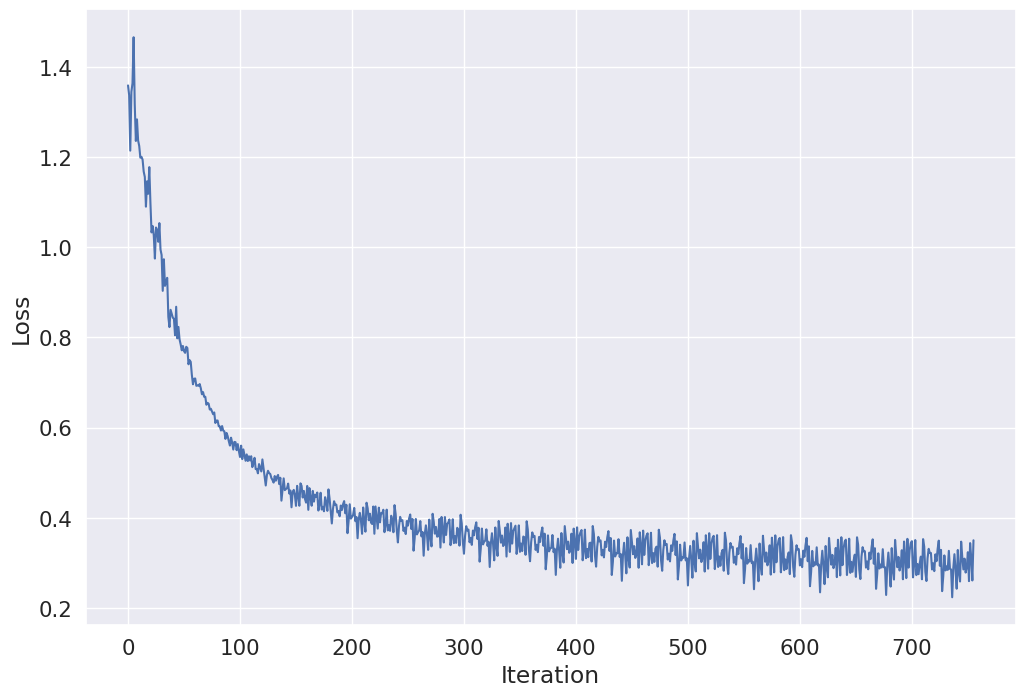

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

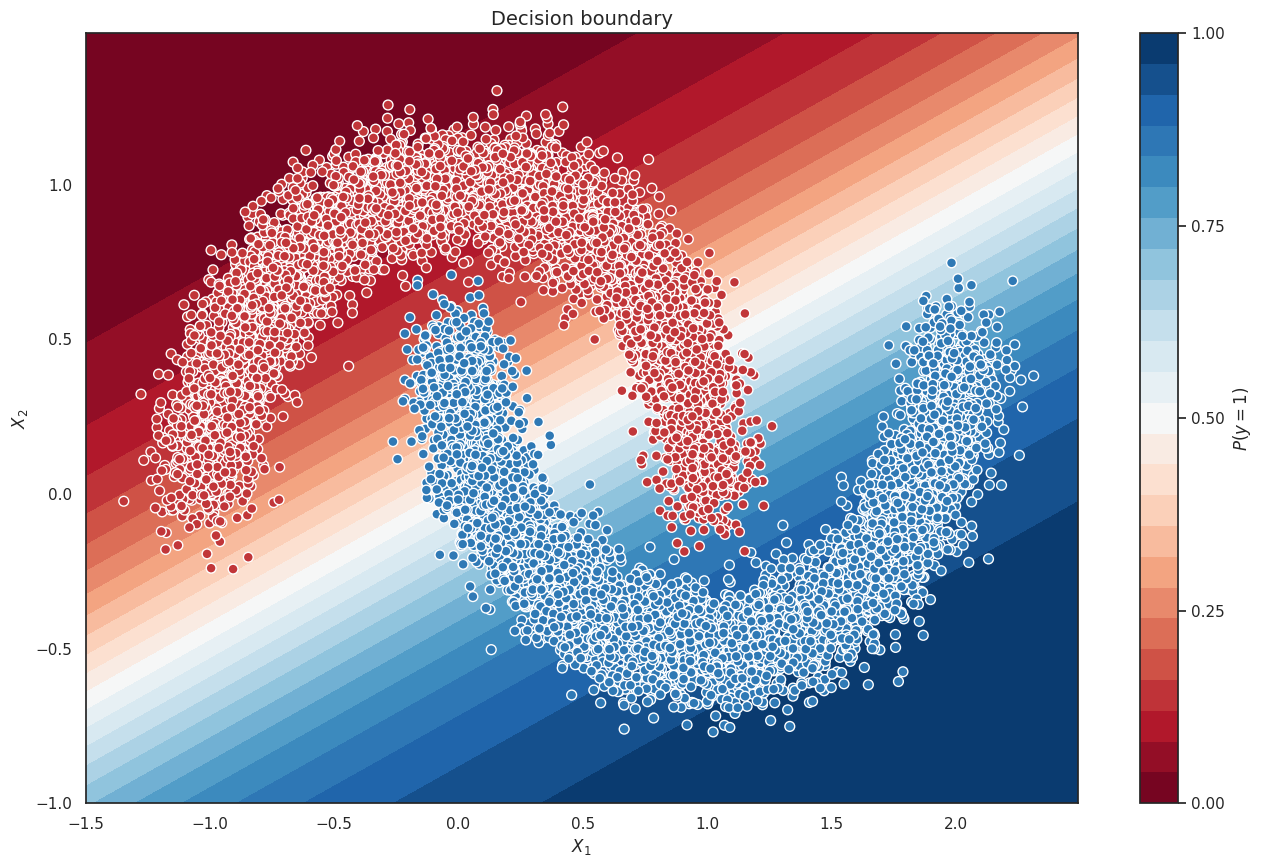

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(model(x_batch))
        preds = np.around(preds, decimals=0)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <YOUR CODE>
        probabilities = torch.sigmoid(model(x_batch))
        preds = (probabilities > 0.5).type(torch.long)
        #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val, preds)
accuracy

0.8668

In [17]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val, preds)
accuracy

0.8668

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [18]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_dataloader =  DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [19]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [20]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(x_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9064333333333333
Loader: valid. Accuracy: 0.9477
Epoch: 2
Loader: train. Accuracy: 0.9461
Loader: valid. Accuracy: 0.9467
Epoch: 3
Loader: train. Accuracy: 0.956
Loader: valid. Accuracy: 0.9566
Epoch: 4
Loader: train. Accuracy: 0.9599
Loader: valid. Accuracy: 0.9378
Epoch: 5
Loader: train. Accuracy: 0.9624833333333334
Loader: valid. Accuracy: 0.9658
Epoch: 6
Loader: train. Accuracy: 0.966
Loader: valid. Accuracy: 0.9649
Epoch: 7
Loader: train. Accuracy: 0.9669666666666666
Loader: valid. Accuracy: 0.9589
Epoch: 8
Loader: train. Accuracy: 0.9686166666666667
Loader: valid. Accuracy: 0.9608
Epoch: 9
Loader: train. Accuracy: 0.9708666666666667
Loader: valid. Accuracy: 0.965
Epoch: 10
Loader: train. Accuracy: 0.9709166666666667
Loader: valid. Accuracy: 0.9556


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9477, 0.9467, 0.9566, 0.9378, 0.9658, 0.9649, 0.9589, 0.9608, 0.965, 0.9556]

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
    )

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(x_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']
    

In [ ]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(negative_slope = 0.2))

Epoch: 1
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 2
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 3
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 4
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 5
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 6
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 7
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 8
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 9
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 10
Loader: train. Accuracy: 0.051833333333333335
Loader: valid. Accuracy: 0.0553
Epoch: 1
Loader: train. Accuracy: 0.11626666666666667
Loader: valid. Accuracy: 0.1144
Epoch: 2
Loader: train. Accuracy: 0.1162666

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

In [ ]:
print(plain_accuracy)
print(relu_accuracy)
print(leaky_relu_accuracy)
print(elu_accuracy)

[0.0553, 0.0553, 0.0553, 0.0553, 0.0553, 0.0553, 0.0553, 0.0553, 0.0553, 0.0553]
[0.1144, 0.1144, 0.1144, 0.1144, 0.1144, 0.1144, 0.1144, 0.1144, 0.1144, 0.1144]
[0.1288, 0.1288, 0.1288, 0.1288, 0.1288, 0.1288, 0.1288, 0.1288, 0.1288, 0.1288]
[0.9477, 0.9467, 0.9566, 0.9378, 0.9658, 0.9649, 0.9589, 0.9608, 0.965, 0.9556]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

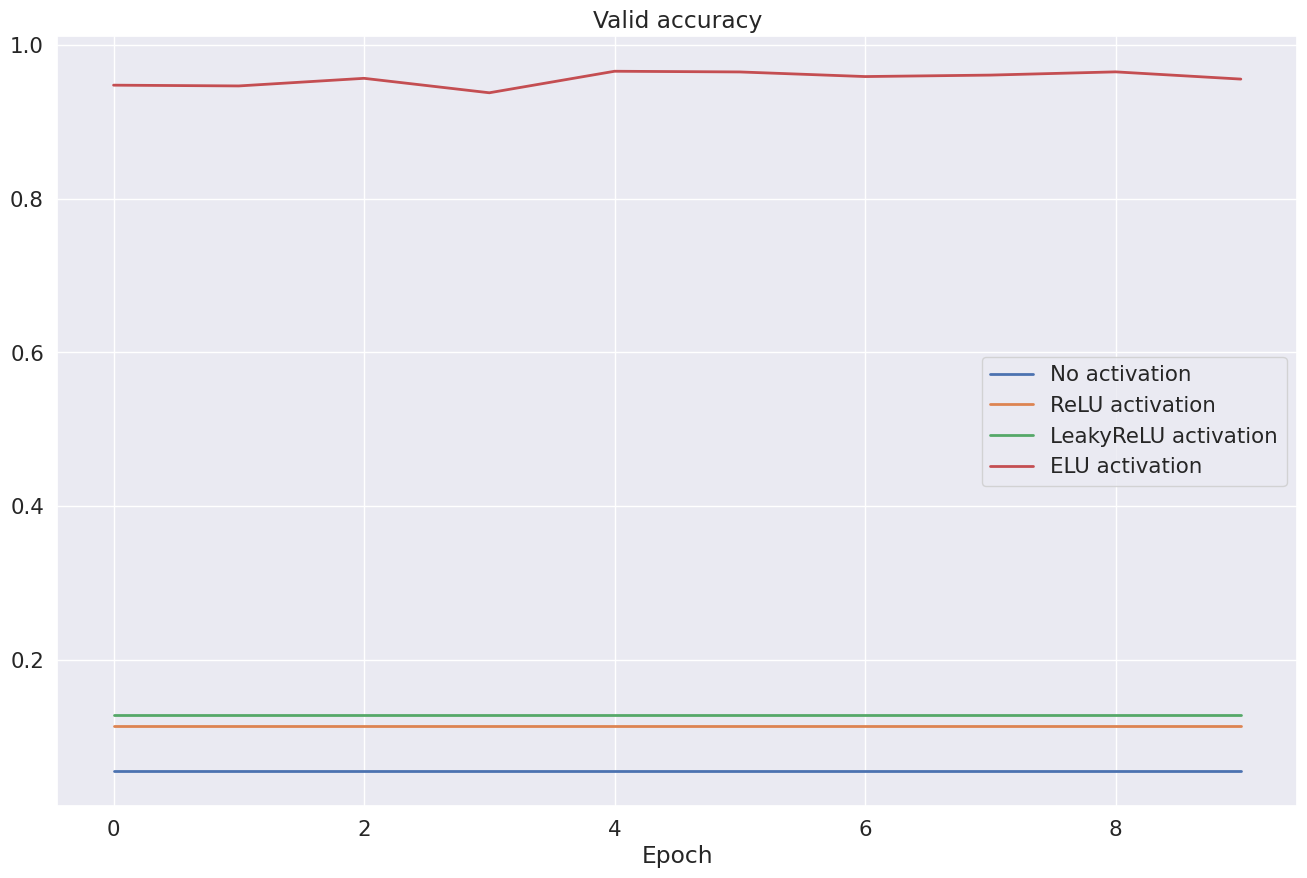

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

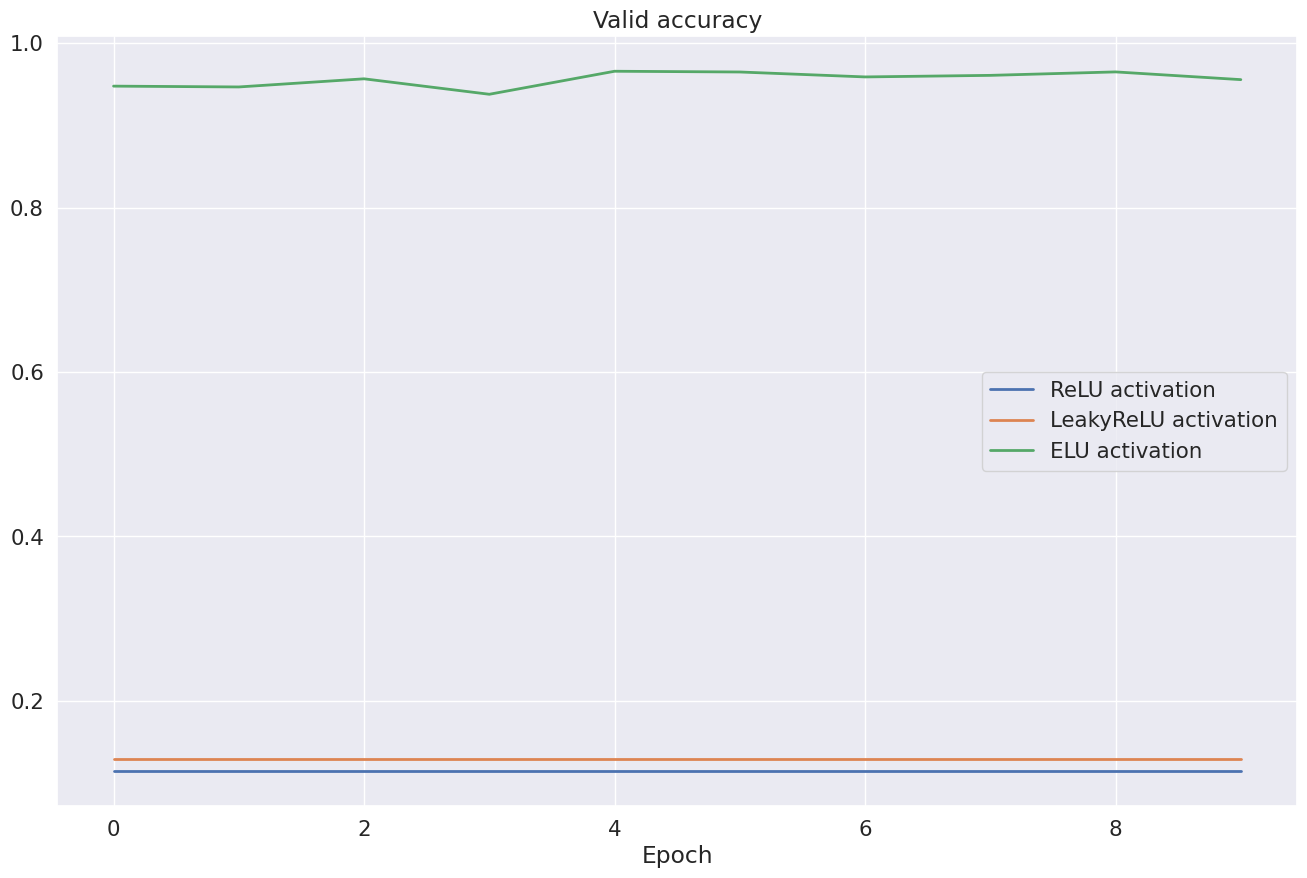

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-09-20 21:02:47--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village.kz (img.the-village.kz)… 5.9.226.237
Подключение к img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... соединение установлено.
ОШИБКА: альтернативное имя субъекта сертификата не совпадает с именем
запрошенного узла ‘img.the-village.kz’.
Для небезопасного подключения к img.the-village.kz используйте параметр «--no-check-certificate».


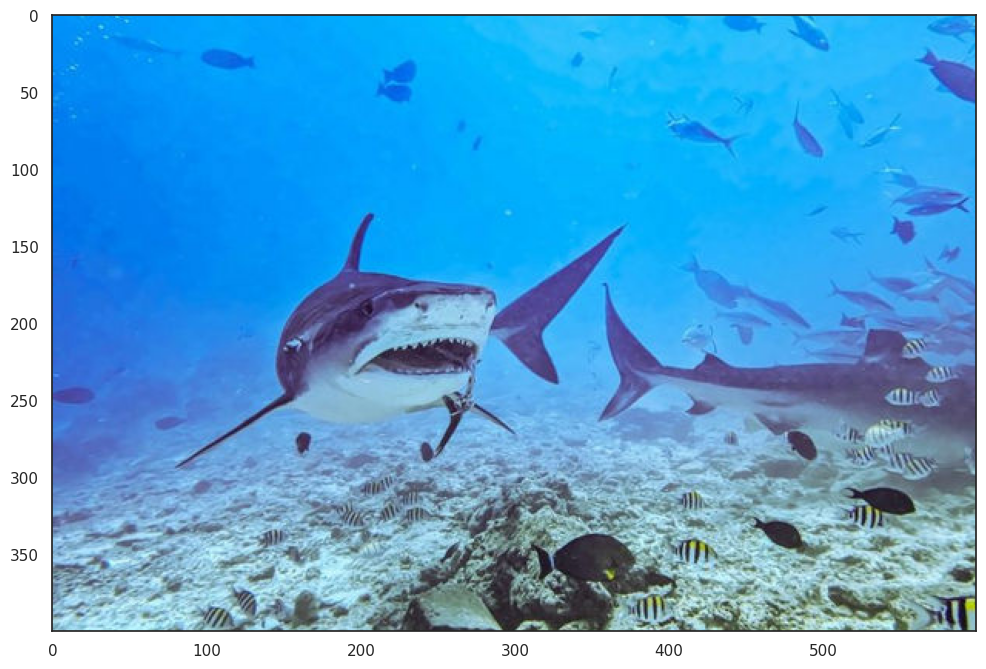

In [23]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [24]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

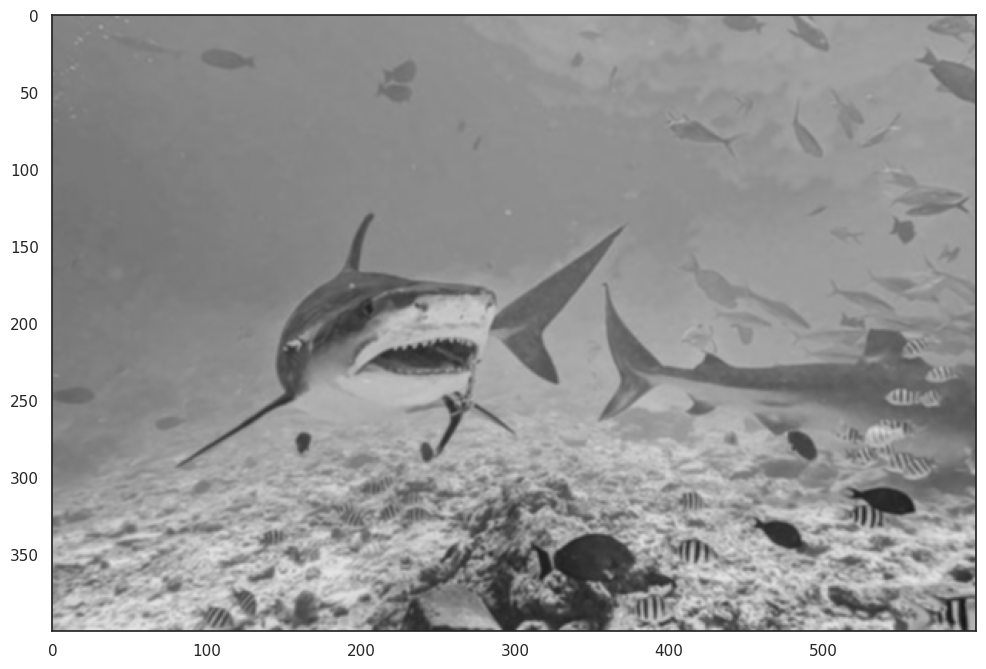

In [25]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [43]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)  # !!!
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        #print(x.shape)
        
        x = x.view(-1, 16 * 5 * 5)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [44]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [45]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all = len(x_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9546333333333333
Loader: valid. Accuracy: 0.9741
Epoch: 2
Loader: train. Accuracy: 0.9815666666666667
Loader: valid. Accuracy: 0.9825
Epoch: 3
Loader: train. Accuracy: 0.98595
Loader: valid. Accuracy: 0.9872
Epoch: 4
Loader: train. Accuracy: 0.98795
Loader: valid. Accuracy: 0.9862
Epoch: 5
Loader: train. Accuracy: 0.99015
Loader: valid. Accuracy: 0.9881
Epoch: 6
Loader: train. Accuracy: 0.991
Loader: valid. Accuracy: 0.9883
Epoch: 7
Loader: train. Accuracy: 0.9925
Loader: valid. Accuracy: 0.9862
Epoch: 8
Loader: train. Accuracy: 0.9927666666666667
Loader: valid. Accuracy: 0.9886
Epoch: 9
Loader: train. Accuracy: 0.9935166666666667
Loader: valid. Accuracy: 0.9859
Epoch: 10
Loader: train. Accuracy: 0.9930833333333333
Loader: valid. Accuracy: 0.9877


In [46]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**